In [4]:
# Importing dependencies
import os
os.system('pip install nilearn')
import pandas as pd
import pickle
import nilearn
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import new_img_like, load_img, index_img, clean_img, concat_imgs
from nilearn.plotting import plot_stat_map, plot_img, show
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, permutation_test_score
from nilearn import decoding
from nilearn.decoding import SearchLight
from sklearn import naive_bayes, model_selection #import GaussianNB
from sklearn.svm import LinearSVC
from nilearn.input_data import NiftiMasker
from datetime import datetime
import nibabel as nib

#### Fetching events from log-files and first level model

In [14]:
# loading the events file for each run
n_runs = 6
words = ["beer", "bread", "cheese", "chocolate", "coffee", "gum", "honey", "jam", "lemonade", "medicine", "pie", "rum", "spaghetti", "tea", "tobacco"]
idxs = []
inc = 0

# creating list of lists of event indices
for i in range(n_runs):
    data=pd.read_csv(f'/work/82777/BIDS/sub-0093/func/sub-0093_task-EPIsequencewords_run-{i+1}_events.tsv',sep='\t')
    idxs.append(list(data[data['word'].isin(words)].index + inc))
    inc += 120
index_list = [idx for sublist in idxs for idx in sublist]

In [3]:
import pickle

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))

# Getting the first level models from tutorial 13:
f = open('/work/MR Tutorial - Kathrine/WordFace_first_level_models_food_random.pkl', 'rb')
models, models_run_imgs, models_events, models_confounds = pickle.load(f)
f.close()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Starting cell: 15:26:14
Finishing cell: 15:26:19


#### Loading the insula mask from Juelich

In [5]:
test_img = nib.load(models_run_imgs[0][0]) # A randomly chosen brain image. All we need is it's shape and affine matrix.

In [6]:
# Specify atlas name
#atlas_name = "cort-maxprob-thr50-2mm"
atlas_name = 'maxprob-thr0-1mm'

# Download atlas (NOTE: The first time you use this function it is likely to download a million different atlases for some reason. I suggest
# preparing an "atlases" folder and telling it to dump them there.)
# It's a weird function: Play around with it a bit. Once downloaded, the atlases are stored as nii.gz files, so they can also be loaded with
# nibabel.load().
#atlas = nilearn.datasets.fetch_atlas_harvard_oxford(atlas_name, data_dir="/work/MR Tutorial - Kathrine/atlases", symmetric_split=False, resume=True, verbose=1)
atlas = nilearn.datasets.fetch_atlas_juelich(atlas_name, data_dir="/work/MR Tutorial - Kathrine/atlases", symmetric_split=False, resume=True, verbose=1)

# PREPARING ATLAS
atlas_img = atlas["maps"] # Returns a NiftiImage

atlas_data = atlas_img.get_fdata() # This returns a 3D (or 4D for probabilistic atlases) numpy array containing a bunch of numbers.
# These numbers are labels corresponding to brain regions.

# These labels can be found here!

# Get labels 
labels = atlas["labels"] ## <- This object here is VERY IMPORTANT. It is a list of all the brain regions the atlas has labelled.
# The atlas is zero-indexed. This means that the first element in the list ("Background" in this case) is labelled 0.
# The inferior frontal gyrus (pars opercularis and pars triangularis) are labelled 5 and 6, etc.

# So what shape is this atlas? Is is the same as the shape of our data?

print("Data:", test_img.header.get_zooms())
print(test_img.shape)
print("Atlas:", atlas_img.header.get_zooms())
print(atlas_img.shape)

print("Oh no, the voxels are different sizes, and the xyz coordinates don't match either!")

Data: (2.526, 2.526, 3.0, 1.0)
(78, 92, 65, 600)
Atlas: (1.0, 1.0, 1.0)
(182, 218, 182)
Oh no, the voxels are different sizes, and the xyz coordinates don't match either!


In [7]:
from nilearn.image import resample_img as resample

# Get the affine matrix from one of our data images
target_affine = test_img.affine

# Get the shape of our data (NOTE: Our data is 4D shaped, because we have 600 images. In this case, we only want the xyz dimension!)
shape = test_img.shape
target_shape = [shape[0], shape[1], shape[2]]

# Run the resample function to get a resampled atlas!
resampled_atlas =resample(atlas_img,target_affine = target_affine, target_shape = target_shape, interpolation = 'nearest')

# Call .get_fdata() on resampled_atlas to get a numpy array of brain region labels.
resamp_data = resampled_atlas.get_fdata()

# Create a copy of this numpy array, which we want to fill with 0's and 1's.
mask = resamp_data.copy()

print("Check that it has the right voxel size and shape:")
print("Data:", test_img.header.get_zooms(), test_img.shape)
print("Atlas:", resampled_atlas.header.get_zooms(), resampled_atlas.shape)
print("Yay!")

Check that it has the right voxel size and shape:
Data: (2.526, 2.526, 3.0, 1.0) (78, 92, 65, 600)
Atlas: (2.526, 2.526, 3.0) (78, 92, 65)
Yay!


In [8]:
atlas.labels[21:24]

['GM Insula Id1', 'GM Insula Ig1', 'GM Insula Ig2']

575
575.0


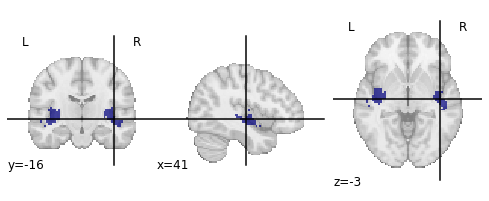

In [11]:
# For-loop time! (There are probably more efficient ways to do this, but it really doesn't take that long)
x = resamp_data.shape[0]
y = resamp_data.shape[1]
z = resamp_data.shape[2]

# This will set all elements of mask to either 0 or 1. In this example, we've chosen the labels 5, 6 and 40
# corresponding roughly to Broca's area
# and the fusiform gyrus - but honestly, we still need to research it a bit more before we settle on anything.

m = 0 # Sanity check variable.
for i in range(0, x):
    for j in range(0, y):
        for k in range(0, z):
            if resamp_data[i][j][k] in [21,22,23]: ## <-------- THIS IS WHERE YOU PUT THE BRAIN LABELS YOU WANT!
                m += 1 # Count how many 1's are placed.
                mask[i][j][k] = 1
            else:
                mask[i][j][k] = 0
print(m)
print(np.sum(mask)) # Ideally this and m should be equal.

# In order for the mask to be used in nilearn, we need to convert it from numpy array back to a nifti file.
# This means we need to supply it with our data's affine matrix again.
mask_nifti_insula = nib.Nifti1Image(mask, affine = target_affine)

from nilearn import plotting
# Finally, let's plot it.
plotting.plot_roi(mask_nifti_insula) # The mask you've just created. Should show at least one of the brain areas you've picked
# (you might not be able to see all of them.)

In [4]:
import pandas as pd
N = 120
trials = pd.DataFrame(models_events[19][0], columns=['onset'])
trials.loc[:, 'duration'] = 0.7
trials.loc[:, 'trial_type'] = ['t_'+str(i).zfill(3) + '_' + models_events[19][0]['trial_type'][i-1]  for i in range(1, N+1)]
trials

,onset,duration,trial_type
0,7.322894,0.7,t_001_Random
1,17.320740,0.7,t_002_Random
2,27.322096,0.7,t_003_Random
3,34.721112,0.7,t_004_Random
4,47.322326,0.7,t_005_Random
...,...,...,...
115,551.037824,0.7,t_116_Random
116,561.038179,0.7,t_117_Random
117,571.054056,0.7,t_118_Random
118,581.055018,0.7,t_119_Random


#### Creating the new design matrix

In [5]:
import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix
import numpy as np
lsa_dm=[]

for ii in range(len(models_events[19])): # looping through each session
    # N=number of events
    N=models_events[19][ii].shape[0] # getting the number of events i.e. the row of the events df
    t_fmri = np.linspace(start = 0, stop = 600, num = 610,endpoint=False) # numpy array of number from 0 to 600
    # We have to create a dataframe with onsets/durations/trial_types
    # No need for modulation!
    
    # concatenate subject with confounds

    trials = pd.DataFrame(models_events[19][ii], columns=['onset']) # extracting the event onsets for the first participant
    trials.loc[:, 'duration'] = 0.7 # adding an additional columns with durations all set to 0.7
    trials.loc[:, 'trial_type'] = ['t_'+str(i).zfill(3) + '_' + models_events[19][0]['trial_type'][i-1]  for i in range(1, N+1)] # adding a column of trial type names

    # lsa_dm = least squares all design matrix
    lsa_dm.append(make_first_level_design_matrix(  # append the design matrix
        frame_times=t_fmri,  # we defined this earlier 
        events=trials,
        hrf_model='glover',
        drift_model='cosine'  
    ))

# Check out the created design matrix
# Note that the index represents the frame times

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Finishing cell: 17:01:51


Finishing cell: 17:02:01


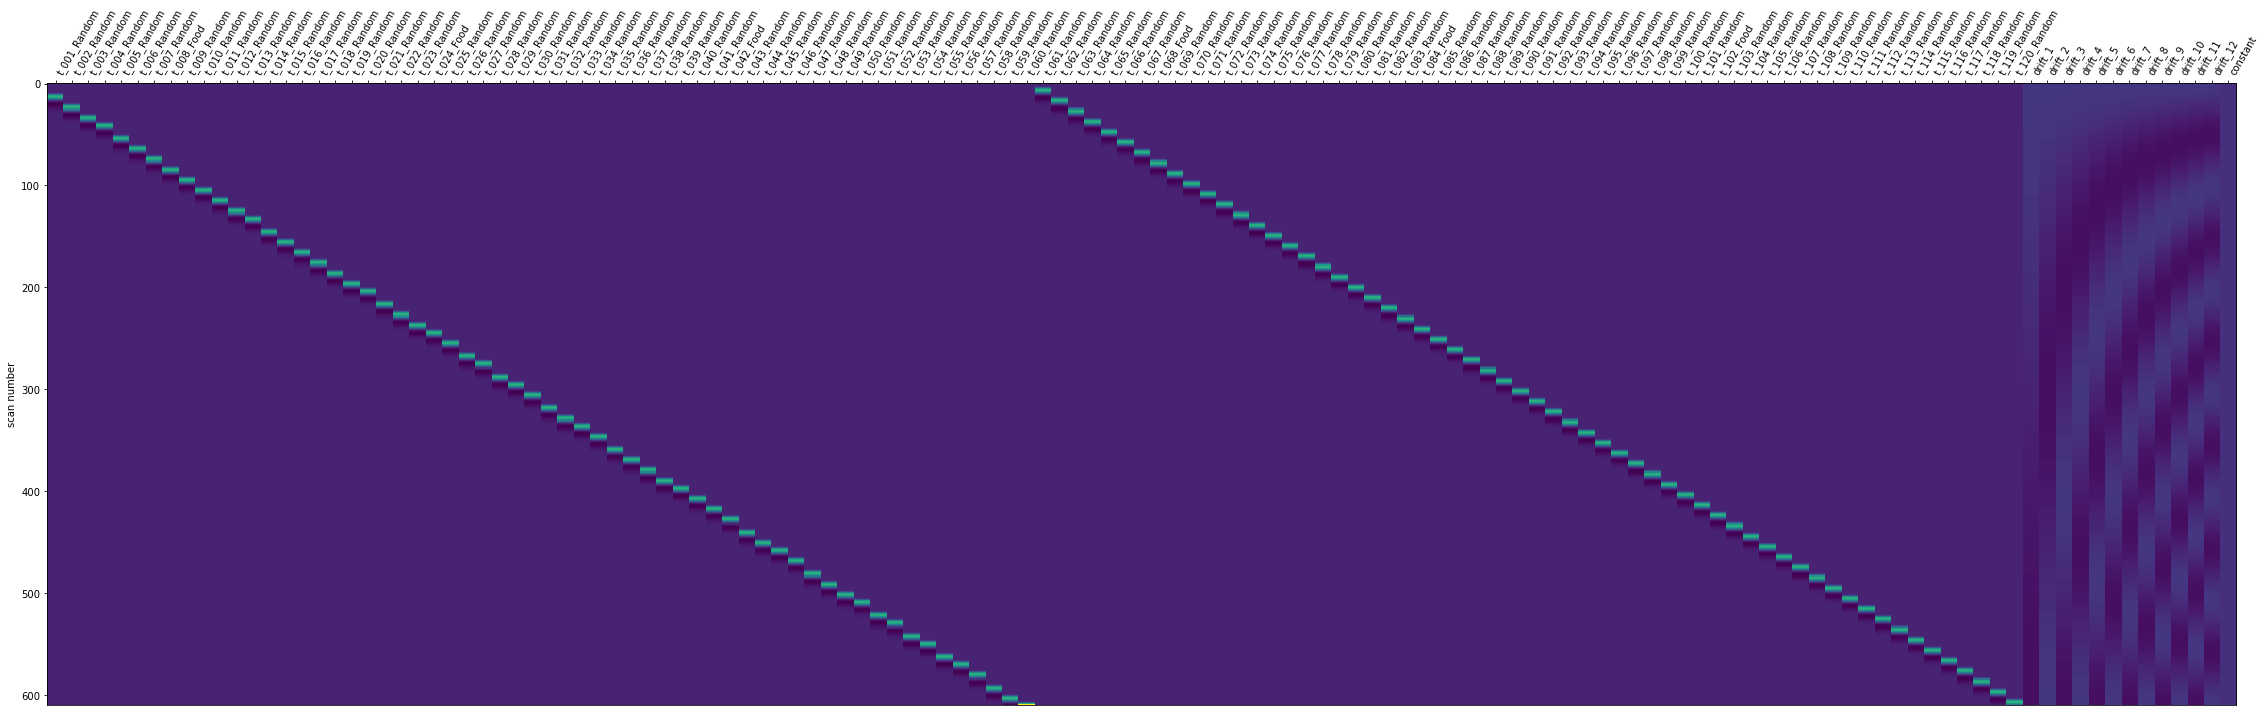

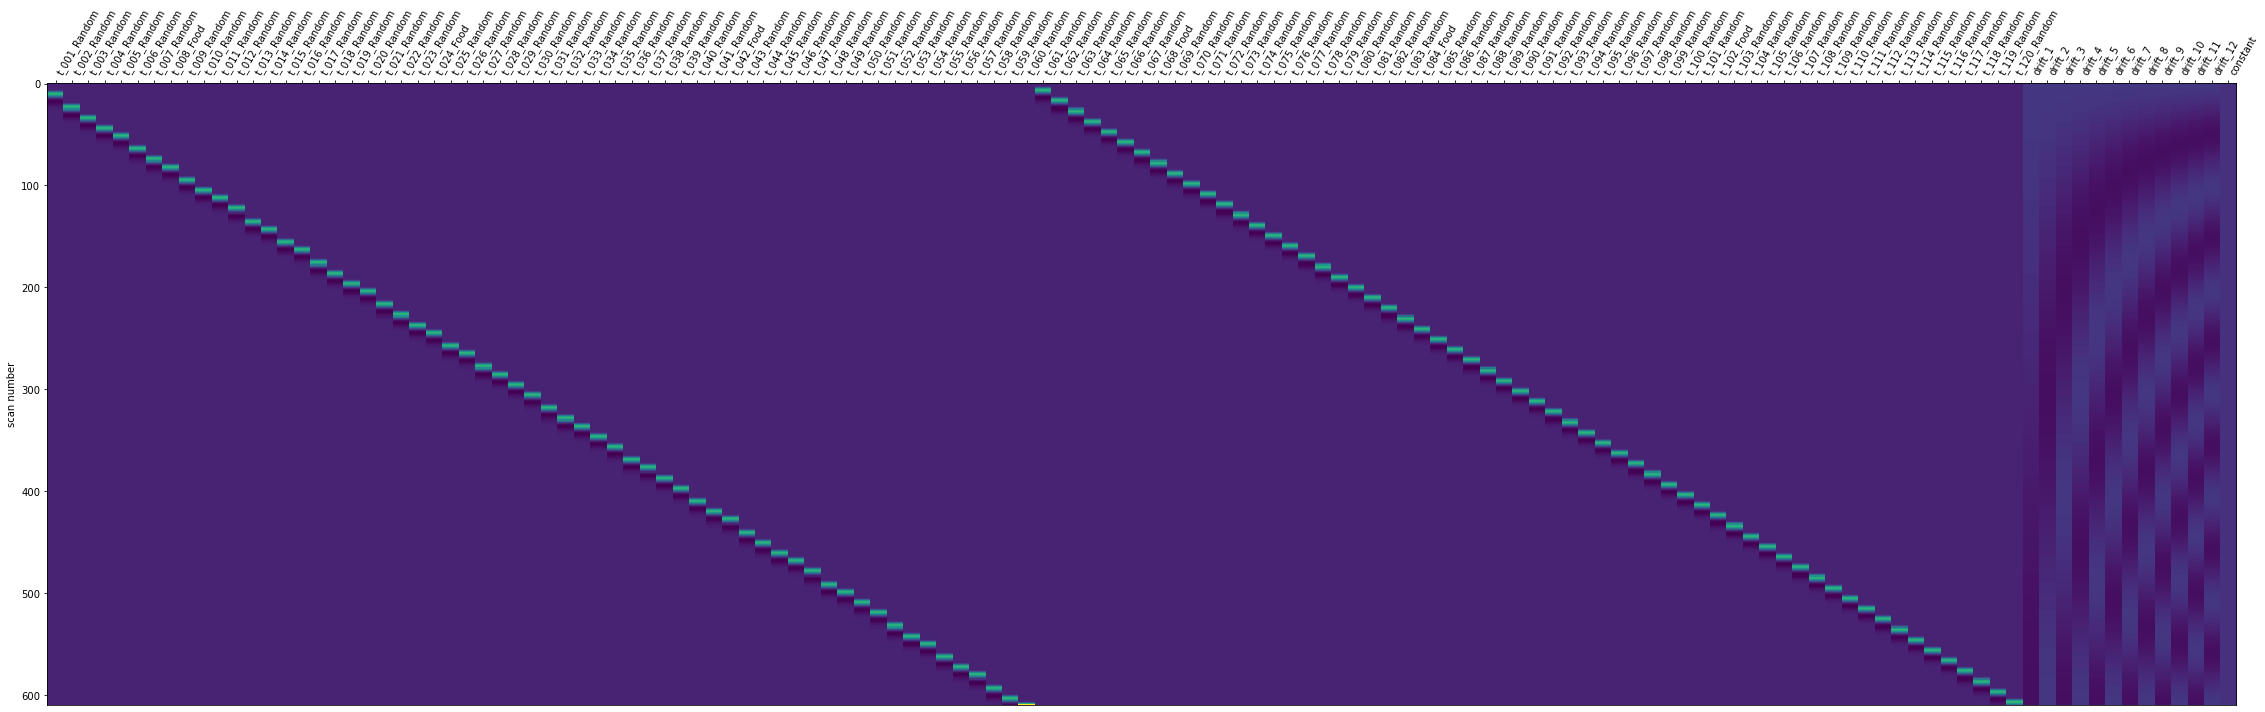

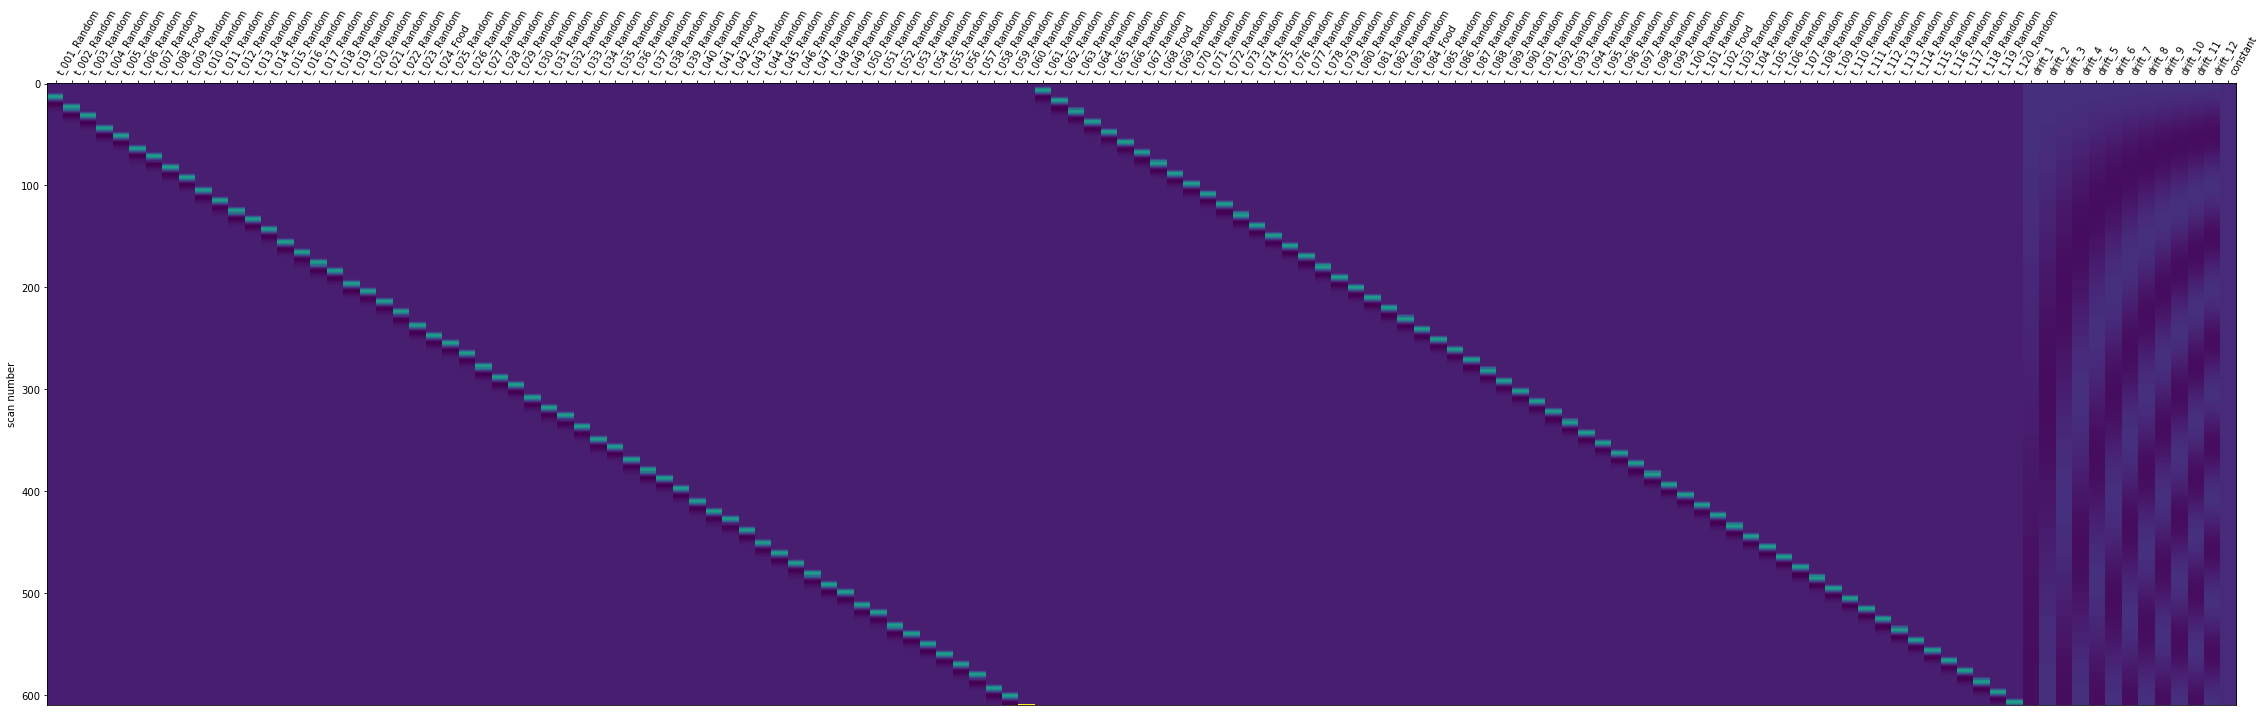

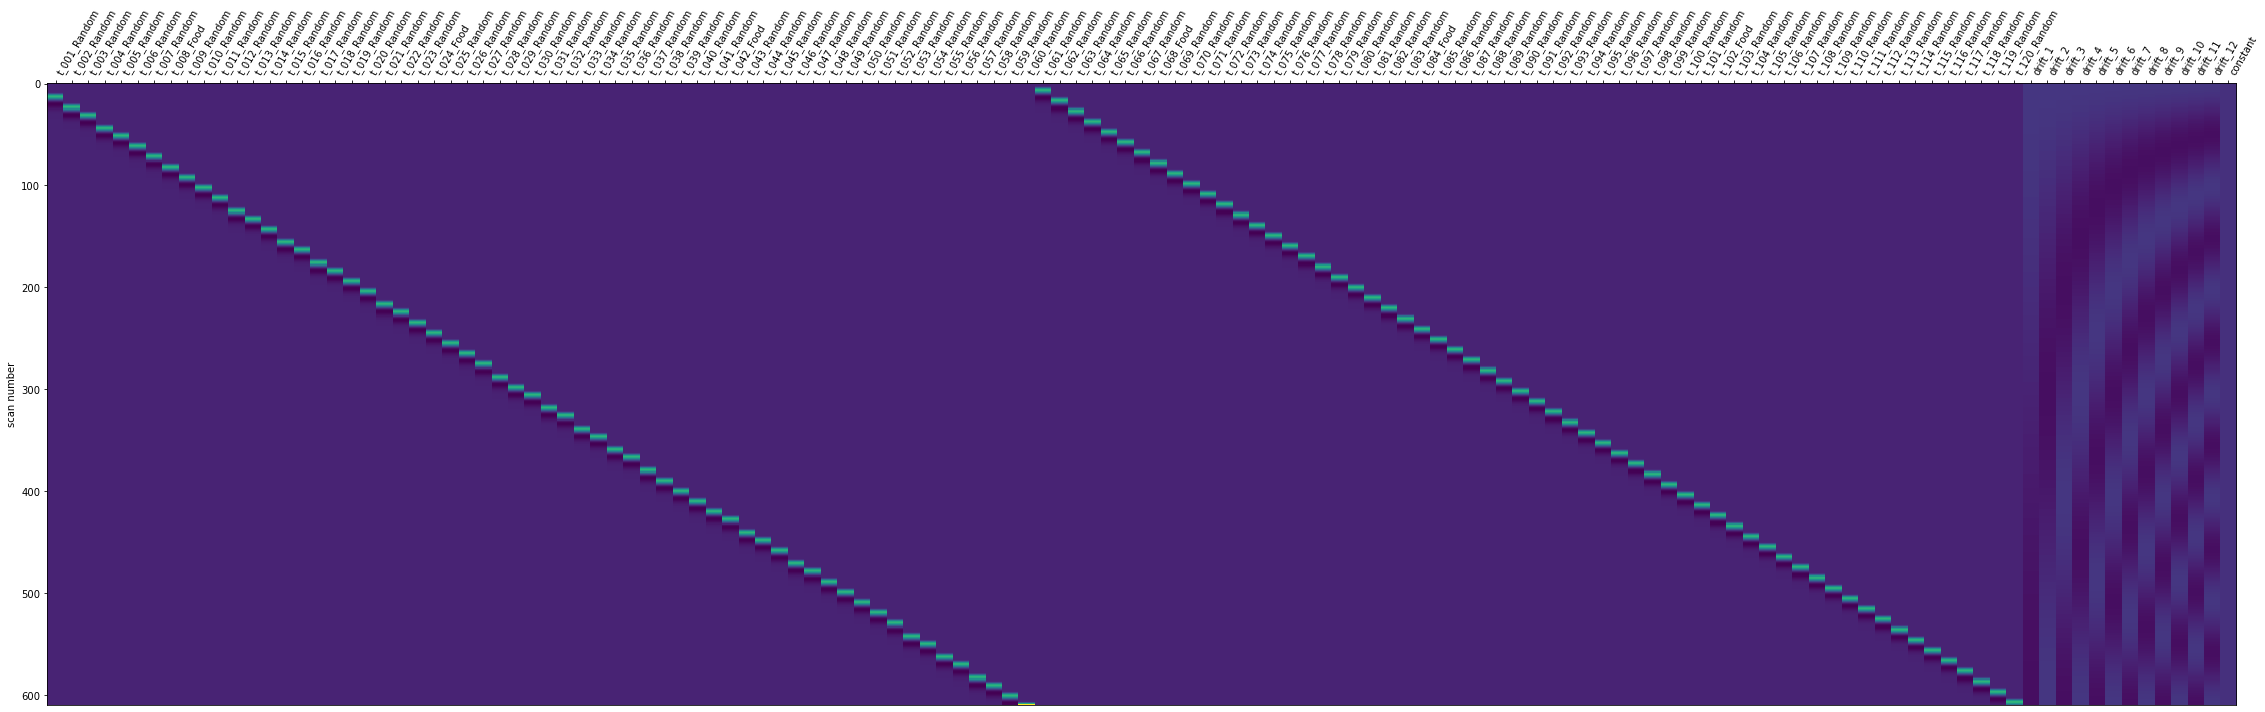

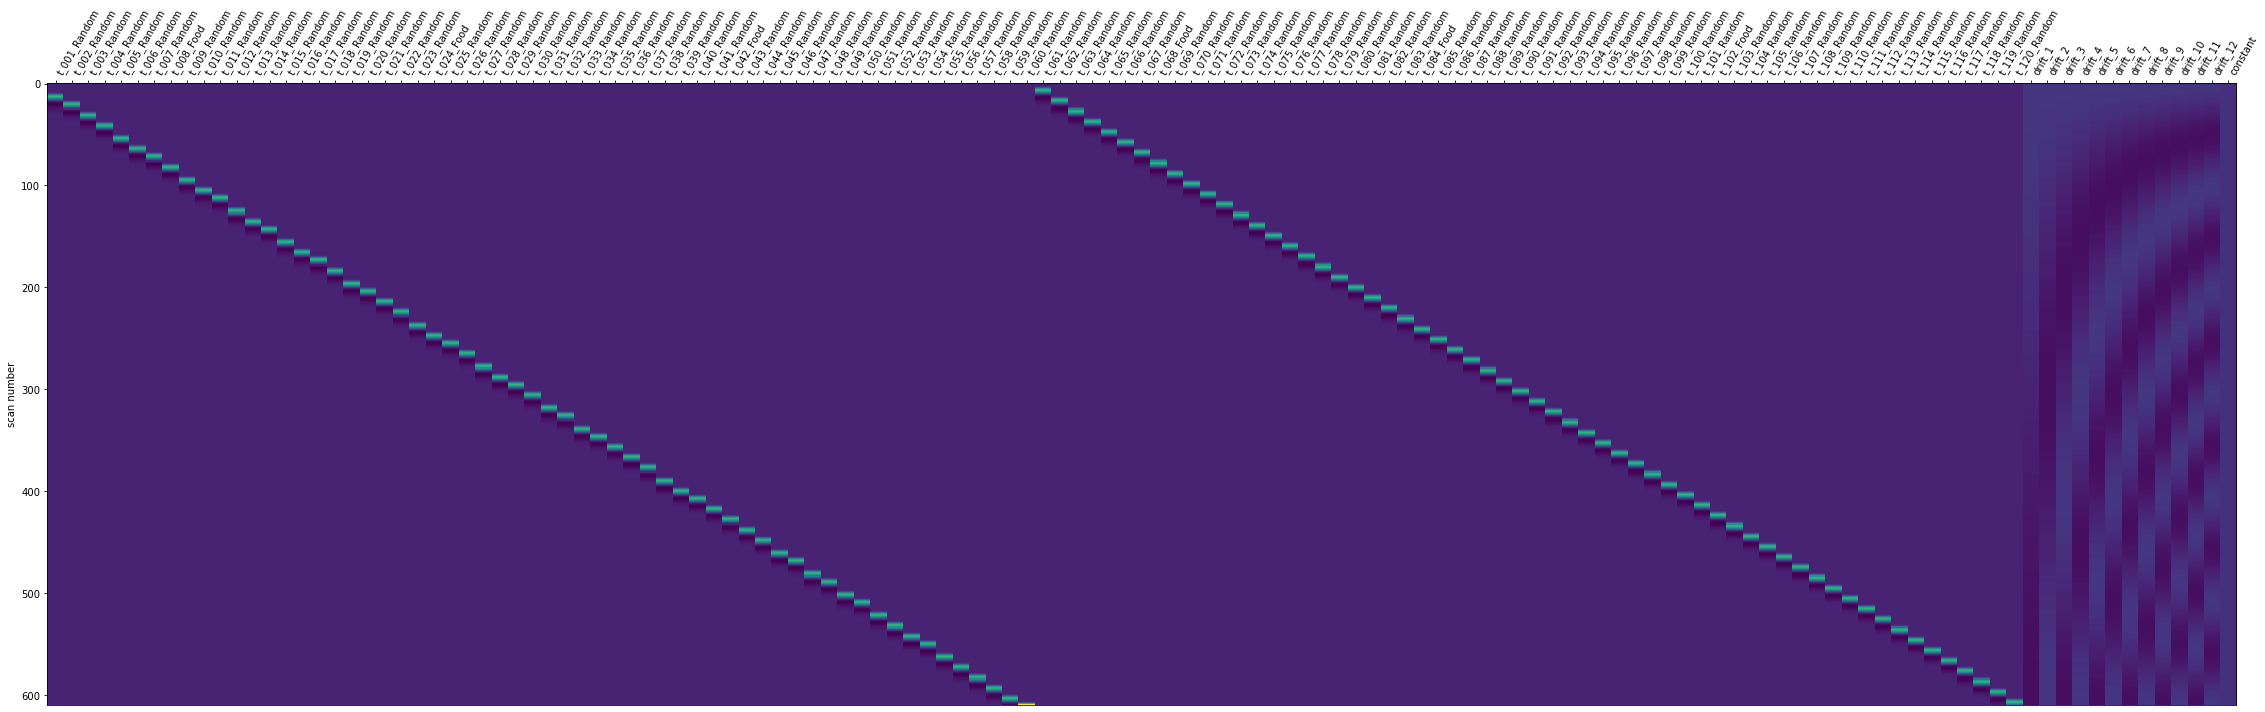

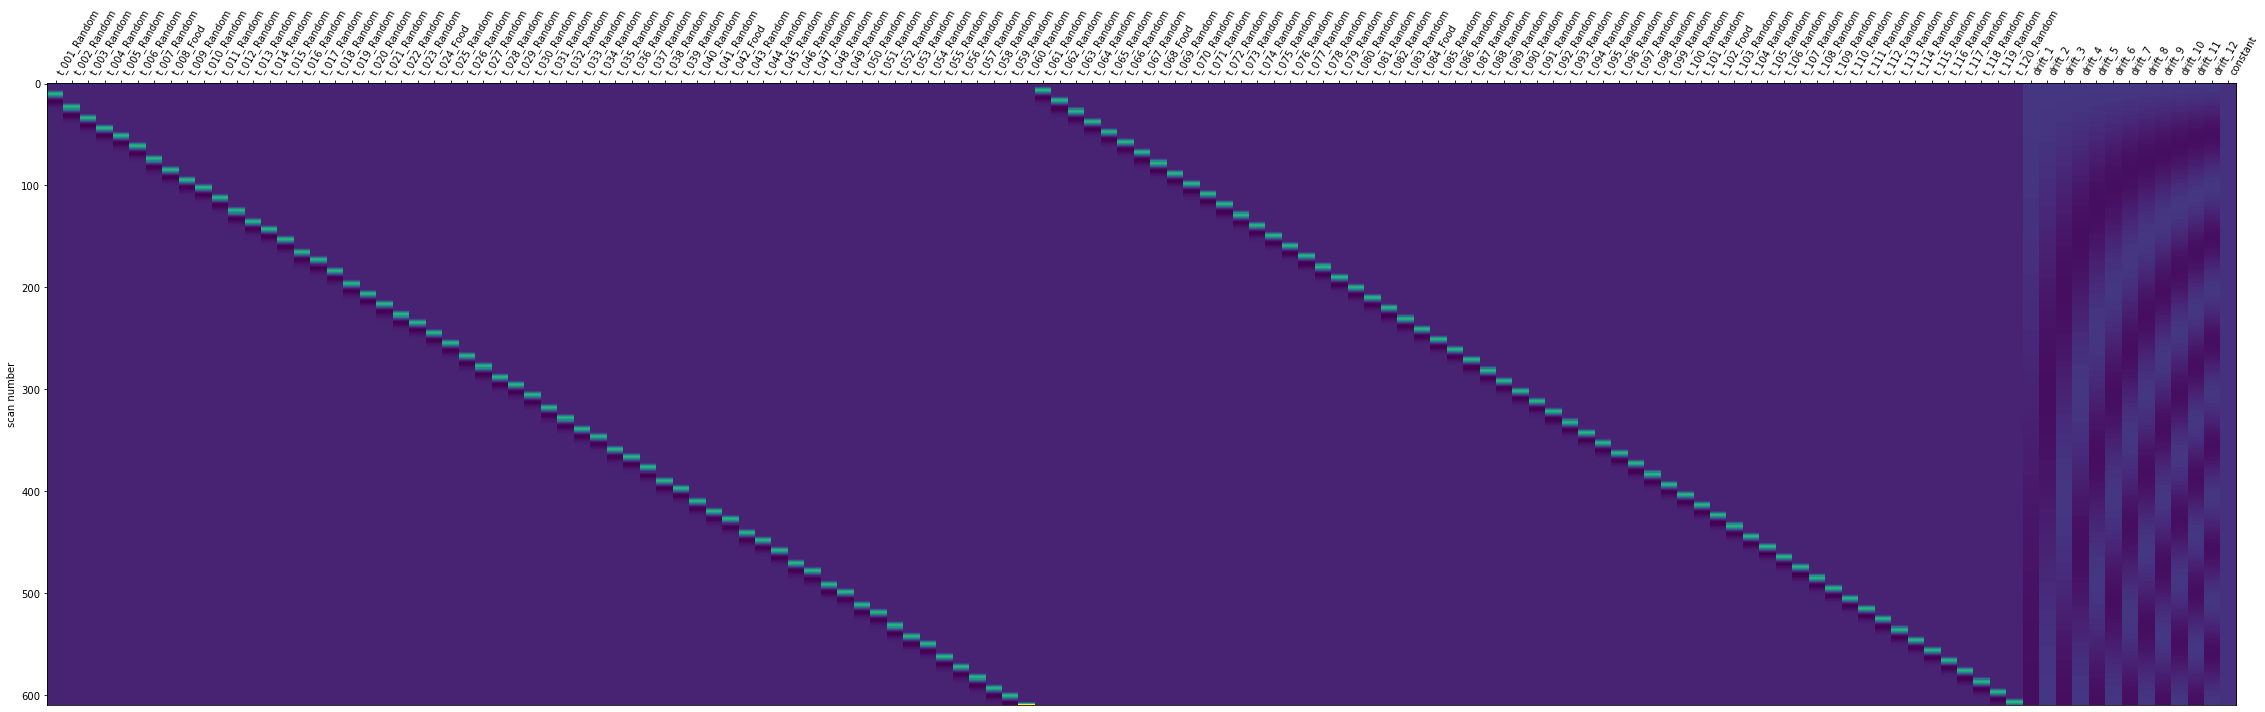

In [6]:
from nilearn.plotting import plot_design_matrix
for ii in range(len(models_events[19])): # plotting the design matrix for each of the six sessions
    plot_design_matrix(lsa_dm[ii]); 

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

#### Fitting the GLM to each session

In [178]:
from nilearn.glm.first_level import FirstLevelModel
model1=[]
for ii in range(len(models_events[19])): # looping through each session
    print(ii)
    # Get data and model info for 1st participant, 1st session
    imgs1=models_run_imgs[19][ii]
    confounds1=models_confounds[19][ii]
    model1.append(FirstLevelModel())
    #Fit the model
    print('Fitting a GLM')
    model1[ii].fit(imgs1,confounds1,design_matrices=lsa_dm[ii])

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

0
Fitting a GLM


/opt/conda/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:470: UserWarning: If design matrices are supplied, confounds and events will be ignored.
  warn(


1
Fitting a GLM


/opt/conda/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:470: UserWarning: If design matrices are supplied, confounds and events will be ignored.
  warn(


2
Fitting a GLM


/opt/conda/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:470: UserWarning: If design matrices are supplied, confounds and events will be ignored.
  warn(
/opt/conda/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


3
Fitting a GLM


/opt/conda/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:470: UserWarning: If design matrices are supplied, confounds and events will be ignored.
  warn(


4
Fitting a GLM


/opt/conda/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:470: UserWarning: If design matrices are supplied, confounds and events will be ignored.
  warn(


5
Fitting a GLM


/opt/conda/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:470: UserWarning: If design matrices are supplied, confounds and events will be ignored.
  warn(


Finishing cell: 22:10:17


In [ ]:
import pickle

# Saving the objects:
f = open('/work/MR Tutorial - Kathrine/WordFace_first_level_models_all_trials.pkl', 'wb')
pickle.dump([model1, lsa_dm], f)
f.close()

## Getting back the objects:
f = open('/work/MR Tutorial - Kathrine/WordFace_first_level_models_all_trials.pkl', 'rb')
model1, lsa_dm = pickle.load(f)
f.close()

print(model1[0])
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

In [180]:
z_maps = []
conditions_label = []

for ii in range(len(models_events[19])):
    N=models_events[19][ii].shape[0]
    #Make an identity matrix with N= number of trials
    contrasts=np.eye(N) # creating an identity matrix with N number of row
    print(contrasts.shape)
    #Find difference between columns in design matrix and number of trials
    dif=lsa_dm[ii].shape[1]-contrasts.shape[1]
    print(dif)
    #Pad with zeros
    contrasts=np.pad(contrasts, ((0,0),(0,dif)),'constant') # padding the identity matrix with zeros to match design matrix size
    print(contrasts.shape)
    for i in range(N):
        #Add a z-contrast image from each trial
        z_maps.append(model1[ii].compute_contrast(contrasts[i,], output_type='z_score'))
        # Make a variable with condition labels for use in later classification
        conditions_label.append(models_events[19][0]['trial_type'][i])
#        session_label.append(session)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

(120, 120)
13
(120, 133)
(120, 120)
13
(120, 133)
(120, 120)
13
(120, 133)
(120, 120)
13
(120, 133)
(120, 120)
13
(120, 133)
(120, 120)
13
(120, 133)
Finishing cell: 22:18:44


In [15]:
import pickle
#Save the first level models
# Saving the objects:

f = open('/work/MR Tutorial - Kathrine/WordFace_first_level_models_all_trials.pkl', 'wb')
pickle.dump([model1, lsa_dm, conditions_label, z_maps], f)
f.close()


# Getting back the objects:
f = open('/work/MR Tutorial - Kathrine/WordFace_first_level_models_all_trials.pkl', 'rb')
model1, lsa_dm, conditions_label, z_maps = pickle.load(f)
f.close()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Finishing cell: 15:33:55


#### Adapting labels to hypthesis

In [16]:
# Changing condition labels
for i in range(len(conditions_label)): 
    if i in index_list:
        conditions_label[i] = 'Movement'
    else:
        conditions_label[i] = 'Random'


In [17]:
# Reshaping data for classification
# optaining the indexes and stacking them
import random
idx_mov=index_list
print(idx_mov)
idx_ran=[int(i) for i in range(len(conditions_label)) if conditions_label[i]=='Random']
idx_ran = random.sample(idx_ran, len(idx_mov))
print(idx_ran)
idx=np.concatenate((idx_mov, idx_ran))

# extracting the trials that are relevant for the chosen classification
conditions=np.array(conditions_label)[idx.astype('int')]

# concatenating all z-maps into 4 dimensional structure
z_maps_conc=concat_imgs(z_maps)
#print(z_maps_conc.shape) 
z_maps_img = index_img(z_maps_conc, idx)

print(z_maps_img.shape)


[3, 33, 56, 63, 93, 116, 122, 182, 262, 267, 272, 292, 322, 327, 332, 352, 394, 402, 454, 462, 518, 536, 578, 596, 628, 652, 654, 688, 712, 714]
[110, 393, 673, 336, 121, 376, 491, 69, 66, 707, 445, 309, 48, 470, 459, 132, 620, 404, 104, 304, 107, 547, 592, 465, 684, 211, 19, 608, 549, 489]
(78, 92, 65, 60)


In [19]:
# Create training and testing
#Make an index for spliting fMRI data with same size as class labels
possible_idxs = np.arange(conditions.shape[0])

# create training and testing vars on the basis of class labels
idx_train, idx_test, conditions_train, conditions_test = train_test_split(possible_idxs, conditions, test_size=0.2)
# NB!! The conditions are not matching here...

# indexing the z_maps
fmri_img_train = index_img(z_maps_img, idx_train) # train z maps
fmri_img_test = index_img(z_maps_img, idx_test) # test z maps

#Check data sizes
print(fmri_img_train.shape)
print(fmri_img_test.shape)

(78, 92, 65, 48)
(78, 92, 65, 12)


#### Creating a mask and preparing for searchlight

/tmp/ipykernel_978/744719631.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  process_mask = mask_img.get_fdata().astype(np.int)
/tmp/ipykernel_978/744719631.py:16: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask_img = new_img_like(mask_img, process_mask)
/opt/conda/lib/python3.9/site-packag

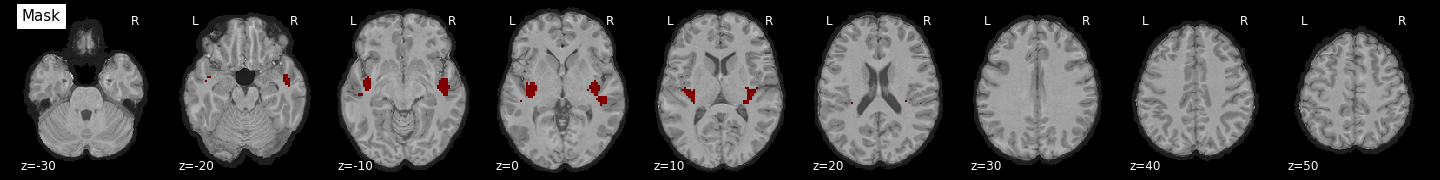

In [41]:
# Preparing for searchlight & create mask

mask_wb_filename='/work/82777/BIDS/derivatives/sub-0093/anat/sub-0093_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
anat_filename='/work/82777/BIDS/derivatives/sub-0093/anat/sub-0093_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
#Load the whole brain mask
#mask_img = load_img(mask_wb_filename) #
mask_img = mask_nifti_insula

# .astype() makes a copy.
process_mask = mask_img.get_fdata().astype(np.int)     
#Set slices below x in the z-dimension to zero (in voxel space)
#process_mask[..., :40] = 0
#Set slices above x in the z-dimension to zero (in voxel space)
#process_mask[..., 150:] = 0
#process_mask[80:110,:,:] = 0
process_mask_img = new_img_like(mask_img, process_mask)

#Plot the searchlight scores on an anatomical background
plot_img(process_mask_img, bg_img=anat_filename,#bg_img=mean_fmri,
         title="Mask", display_mode="z",cut_coords=[-30,-20,-10,0,10,20,30,40,50],
         vmin=.40, cmap='jet', threshold=0.9, black_bg=True)
plt.savefig('/work/MR Tutorial - Kathrine/MR_tutorials/mask.png')

In [ ]:
# The conditions are not in the right order
conditions_train_temp = np.array(conditions_label)[idx_train]

#### Performing searchlight analysis

In [46]:
# The radius is the one of the Searchlight sphere that will scan the volume
import time
start = time.time()
searchlight = SearchLight(
    mask_img,
    estimator=LinearSVC(penalty='l2'),
    process_mask_img=process_mask_img,
    radius=5, n_jobs=-1,
    verbose=10, cv=5)
searchlight.fit(fmri_img_train, conditions_train_temp)
end = time.time()

print(f"Searchlight took: {(end-start)/60} mins")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 63 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   8 out of  63 | elapsed:    4.7s remaining:   32.0s
[Parallel(n_jobs=-1)]: Done  15 out of  63 | elapsed:    4.8s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  22 out of  63 | elapsed:    4.9s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  29 out of  63 | elapsed:    4.9s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  36 out of  63 | elapsed:    4.9s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  43 out of  63 | elapsed:    4.9s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  50 out of  63 | elapsed:    4.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  57 out of  63 | elapsed:    5.0s remaining:    0.5s


Searchlight took: 0.0959946592648824 mins


[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    5.2s finished


In [5]:
#Saving the searchlight analysis
# Saving the objects:
f = open('/work/MR Tutorial - Kathrine/WordFace_first_level_models_all_trials_searchlight_sub0093_insula.pkl', 'wb')
pickle.dump([searchlight], f)
f.close()

# Getting back the objects:
f = open('/work/MR Tutorial - Kathrine/WordFace_first_level_models_all_trials_searchlight_sub0093_full_mask.pkl', 'rb')
#f = open('/work/MR Tutorial - Kathrine/WordFace_first_level_models_all_trials_searchlight_sub0093_insula.pkl', 'rb')
searchlight = pickle.load(f)
f.close()

/home/coder/.local/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearSVC from version 1.1.3 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
searchlight = searchlight[0]

#Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)

nilearn.plotting.plot_glass_brain(searchlight_img, cmap='hot',colorbar=True, threshold=0.01,
                          title='Image pos vs Image neg (unthresholded)',
                          plot_abs=False)

nilearn.plotting.plot_glass_brain(searchlight_img,threshold=0.6,title='Image pos vs Image neg (Acc>0.6')


plot_stat_map(searchlight_img, cmap='jet',threshold=0.6, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='Image pos vs Image neg (Acc>0.6)')
plt.show()

### Finding the 100 most predictive voxels

In [ ]:
# finding the 100 most predictive voxels
print(searchlight.scores_.size)
#Find the percentile that makes the cutoff for the 100 best voxels
perc=100*(1-100.0/searchlight.scores_.size)
#Print percentile
print(perc)
#Find the cutoff
cut=np.percentile(searchlight.scores_,perc)
#Print cutoff
print(cut)
#cut=0
#Make a mask using cutoff

#Load the whole brain mask
mask_img2 = load_img(mask_wb_filename)

# .astype() makes a copy.
process_mask2 = mask_img2.get_data().astype(np.int)
process_mask2[searchlight.scores_<=cut] = 0
process_mask2_img = new_img_like(mask_img2, process_mask2)

### Displaying the 100 most predictive voxels

/opt/conda/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


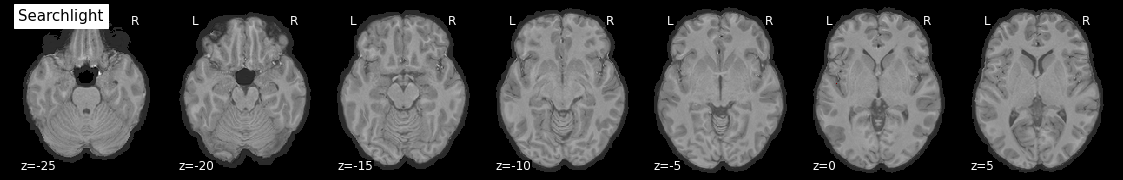

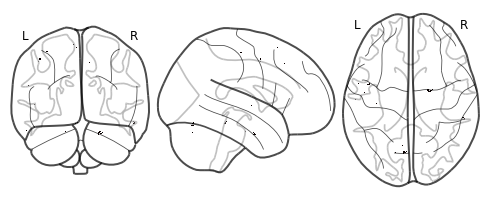

In [32]:
#Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)
#Plot the searchlight scores on an anatomical background
plot_img(searchlight_img, bg_img=anat_filename,#bg_img=mean_fmri,
         title="Searchlight", display_mode="z",cut_coords=[-25,-20,-15,-10,-5,0,5],
         vmin=.40, cmap='jet', threshold=cut, black_bg=True)
#plotting.plot_glass_brain effects
nilearn.plotting.plot_glass_brain(searchlight_img,threshold=cut)
plt.savefig('/work/MR Tutorial - Kathrine/MR_tutorials/100_most_predictive_full_mask_balanced.png')

#### Retrieving mask for classification

In [57]:
# We use masker to retrieve a 2D array ready
#masker = NiftiMasker(mask_img=process_mask2_img, standardize=False)
masker = NiftiMasker(mask_img=mask_nifti_insula, standardize=False) ## Input your own mask in mask_img here!

# for machine learning with scikit-learn
fmri_masked = masker.fit_transform(fmri_img_test)
#Print size of matrix (images x voxels)
print(fmri_masked.shape)

cv_score = cross_val_score(LinearSVC(penalty='l2'), fmri_masked, conditions_test, cv=5)
print(cv_score)
print('Mean prediction score:')
print(np.mean(cv_score))

(12, 575)
[0.66666667 1.         1.         0.         0.5       ]
Mean prediction score:
0.6333333333333333


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


#### Permutation testing

In [58]:
score, permutation_scores, pvalue= permutation_test_score(
    LinearSVC(penalty='l2'), fmri_masked, conditions_test, cv=5, n_permutations=100, 
    n_jobs=-1, random_state=0, verbose=0, scoring=None)
print("Classification Accuracy: %s (pvalue : %s)" % (score, pvalue))

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Classification Accuracy: 0.6333333333333333 (pvalue : 0.22772277227722773)


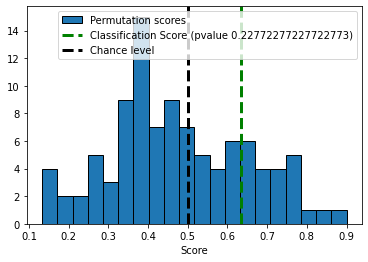

In [60]:
#How many classes
n_classes = np.unique(conditions_test).size

plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance level')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.savefig('/work/MR Tutorial - Kathrine/MR_tutorials/permutation_insula.png')
plt.show()
